In [66]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio

# Reading code from https://www.kaggle.com/code/kennethfilbert/speech-recognition-emotion-bi-gru-crema-d
# Reading of the paths and files

PATH = "./AudioWAV/"

directory_list = os.listdir(PATH)

file_emotion = []
file_path = []
speakers = []

for file in directory_list:
    file_path.append(PATH + file)
    part = file.split('_')
    speakers.append(int(part[0]))
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

crema_df = pd.DataFrame(list(zip(speakers, file_emotion, file_path)),
               columns =['ActorID', 'emotion','path'])
crema_df.head()



,ActorID,emotion,path
0,1001,angry,./AudioWAV/1001_DFA_ANG_XX.wav
1,1001,disgust,./AudioWAV/1001_DFA_DIS_XX.wav
2,1001,fear,./AudioWAV/1001_DFA_FEA_XX.wav
3,1001,happy,./AudioWAV/1001_DFA_HAP_XX.wav
4,1001,neutral,./AudioWAV/1001_DFA_NEU_XX.wav


In [67]:
#Leftside merge of dataframe to have demographic data available. 
demographics = pd.read_csv("data/VideoDemographics.csv")
crema_df = pd.merge(crema_df, demographics, how="left", on=["ActorID", "ActorID"])
print(crema_df.head())


   ActorID  emotion                            path  Age   Sex       Race  \
0     1001    angry  ./AudioWAV/1001_DFA_ANG_XX.wav   51  Male  Caucasian   
1     1001  disgust  ./AudioWAV/1001_DFA_DIS_XX.wav   51  Male  Caucasian   
2     1001     fear  ./AudioWAV/1001_DFA_FEA_XX.wav   51  Male  Caucasian   
3     1001    happy  ./AudioWAV/1001_DFA_HAP_XX.wav   51  Male  Caucasian   
4     1001  neutral  ./AudioWAV/1001_DFA_NEU_XX.wav   51  Male  Caucasian   

      Ethnicity  
0  Not Hispanic  
1  Not Hispanic  
2  Not Hispanic  
3  Not Hispanic  
4  Not Hispanic  


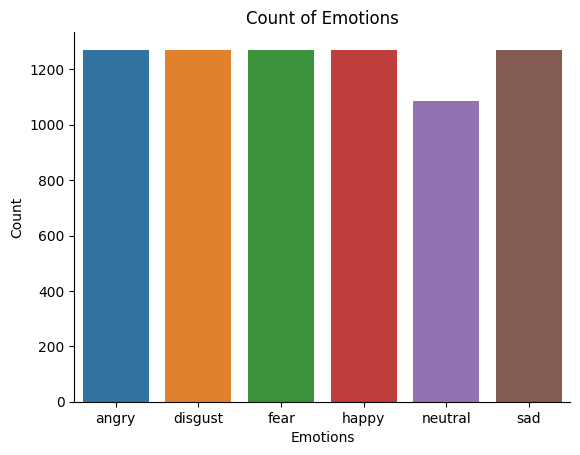

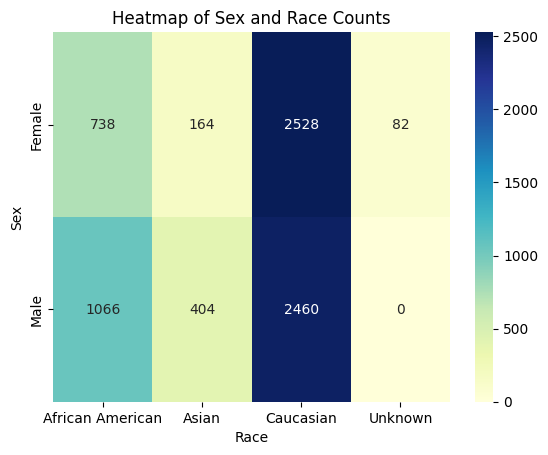

In [68]:
#Show some data-distributions

plt.title('Count of Emotions')
sns.countplot(x = crema_df["emotion"], hue = crema_df["emotion"])
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()


# Create pivot table
pivot_table = pd.crosstab(crema_df['Sex'], crema_df['Race'])
pivot_table = pivot_table.round(0).astype(int)
# Generate heatmap

sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title('Heatmap of Sex and Race Counts')
plt.xlabel('Race')
plt.ylabel('Sex')
plt.show()



In [69]:
#Function definitions for wave plots and spectrograms


def waveplot(data, sr, e):
    plt.figure(figsize = (10, 3))
    plt.title(f"{e} audio waveplot")
    librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize = (12, 3))
    plt.title(f"{e} audio spectrogram")
    librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')



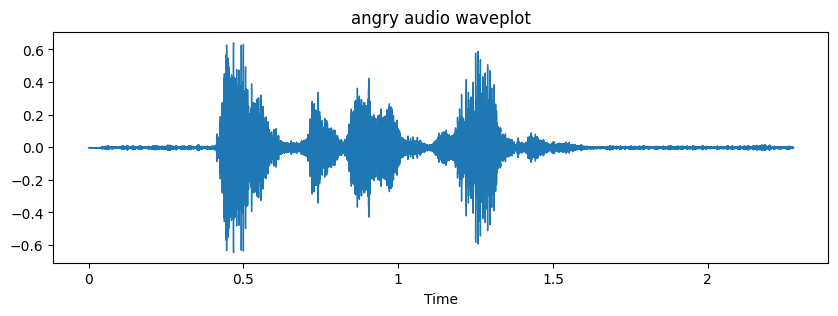

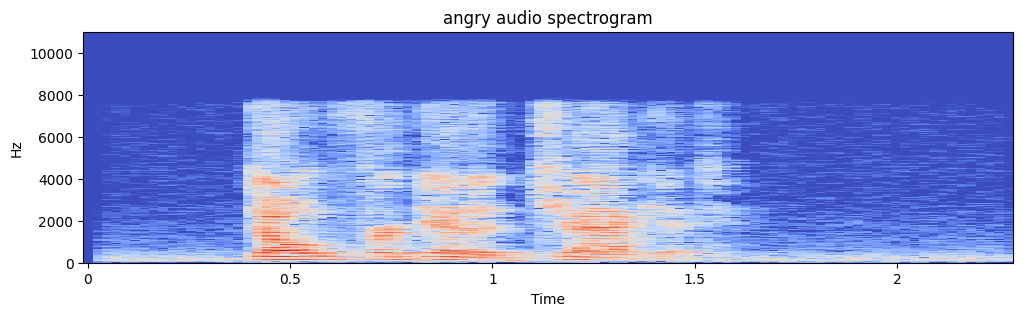

In [70]:
#Sample Display


import numpy as np
path = crema_df.iloc[0]["path"]
emotion = crema_df.iloc[0]["emotion"]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate,emotion)
spectrogram(data, sampling_rate,emotion)
Audio(path)


In [76]:
#Sample Opensmile feauture extraction
import audiofile
import opensmile


class openSmileExtractor():
    def __init__(self,featureLevel = opensmile.FeatureLevel.Functionals):
        self.smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=featureLevel,
    )
    
    def processSignal(self,path):
        signal, sampling_rate = audiofile.read(
            path,
            always_2d=True,
        )
        process = self.smile.process_signal(
            signal,
            sampling_rate
        )
        return process
    
    def processSignals(self,paths):
        process = self.smile.process_files(
            paths,
        )
        return process
    
    def processDF(self, df, filename="opensmileDF.csv"):
        paths = list(df["path"])
        feature_df=self.processSignals(paths)
        final_df = pd.merge(df, feature_df, how="left", left_on=["path"],right_on=["file"])
        final_df.to_csv(filename)
        return final_df

extractor = openSmileExtractor(featureLevel = opensmile.FeatureLevel.Functionals)
print(list(crema_df.iloc[0:3]["path"]))
#res = extractor.processDF(crema_df.iloc[0:3],filename="data/opensmileDF_lowlevel.csv")


['./AudioWAV/1001_DFA_ANG_XX.wav', './AudioWAV/1001_DFA_DIS_XX.wav', './AudioWAV/1001_DFA_FEA_XX.wav']
